In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import glob
import gmplot 
import re
from datetime import datetime,date
from collections import defaultdict
import folium
import json
from folium.plugins import HeatMap
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os 

# Loading and Data Wrangling


*italic*
**bold**

In [5]:
file_names=[]
for name in glob.glob('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/listing*.csv'):
    file_names.append(os.path.basename(name))    

In [6]:
just = 'Standard Price:'
price = re.findall("\d+", just)[0] if re.findall("\d+", just) else None
price

In [7]:
def clean_listing(filename):
    
    listing=pd.read_csv('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/'+filename)
    del_cols=['listing_url','scrape_id','experiences_offered','thumbnail_url','medium_url',
                          'picture_url','xl_picture_url','host_url','host_response_time','host_neighbourhood',
                          'host_response_rate','host_acceptance_rate','host_thumbnail_url',
                          'host_picture_url','host_verifications','calculated_host_listings_count',
                          'calculated_host_listings_count_entire_homes','notes',
                          'calculated_host_listings_count_private_rooms',
                          'calculated_host_listings_count_shared_rooms',
                          'license','jurisdiction_names','square_feet',
                          'weekly_price','monthly_price','neighborhood_overview',
                          'transit','access','interaction','house_rules','space',
                          'host_about','host_name','neighbourhood','smart_location',
                          'minimum_minimum_nights', 'maximum_minimum_nights',
                          'minimum_maximum_nights', 'maximum_maximum_nights','calendar_updated',
                          'calendar_last_scraped','requires_license','minimum_nights_avg_ntm', 
                          'maximum_nights_avg_ntm','market','street','country_code','country','state',
                          'city','host_location','host_total_listings_count','zipcode','cleaning_fee',
                          'security_deposit','host_has_profile_pic','host_listings_count']
    for col in (set(del_cols) & set(listing.columns)):
        listing = listing.drop([col], axis=1)
        
    #listing=listing(subset=['price'])
    #len(listing_20191205.id)==len(listing_20191205.id.unique())
    #listing_20191205.columns

    #Remove listing with id=23043744, because it is an outlier discovered by visualization
    listing = listing[listing.id != 23043744]
    #Remove listing with incorrect reviews per month, first review, number of reviews columns
    listing = listing[listing.id != 507927]
    #correct the listing with 21 bedrooms
    listing.bedrooms[listing.id==39395189]=1
    #remove listings with zero price
    listing=listing[listing.price!=0]
    #fill empty security deposit and cleaning fee columns by zero
    #listing[['security_deposit','cleaning_fee']]=listing[['security_deposit','cleaning_fee']].fillna(0)
    #reviews per month
    listing.fillna({'reviews_per_month':0},inplace=True)
    #listing_20191205.reviews_per_month.isnull().sum()
    #listing_20191205.reviews_per_month.max()
    #drop rows where the bathrooms, bedrooms and beds are NaN
    listing=listing.dropna(subset=['bedrooms', 'bathrooms','beds'])
    
    #date variable list:
    date_variables=['host_since','last_scraped','first_review','last_review']
    #price variable list:
    price_variables=['price','extra_people']
    #convert date variables into datetime object
    listing[date_variables]=listing[date_variables].apply(lambda x: x.astype(str))
    #pd.to_datetime(listing_20191205[date_variables], format='%Y-%m-%d')
    listing[date_variables]=listing[date_variables].apply(pd.to_datetime,format='%Y-%m-%d')
    #listing_20191205[date_variables].dtypes
    #convert price column to numeric
    listing[price_variables]=listing[price_variables].apply(lambda x: x.astype(str).str.replace('$',''))
    listing[price_variables]=listing[price_variables].apply(lambda x: x.astype(str).str.replace(',',''))
    listing[price_variables]=listing[price_variables].apply(pd.to_numeric,errors='coerce', axis=1)
    
    #clean up the strings for zipcode
    #listing.zipcode=listing.zipcode.astype(str).str.replace('CA','')
    #listing.zipcode=listing.zipcode.astype(str).str.replace('Ca','')
    #listing.zipcode=listing.zipcode.astype(str).str.replace('ca','')
    #listing.zipcode=listing.zipcode.astype(str).str.split('-').str[0]
    #listing.zipcode=listing.zipcode.astype(str).str.split('.').str[0]
    #listing.zipcode[listing.zipcode=='139 S Valencia Ave, Glendora']='91471'
    #listing.zipcode[listing.zipcode=='']='90000'
    #listing.zipcode[listing.zipcode=='nan']='90000'
    #listing.zipcode[listing.zipcode=='0000']='90000'
    #listing.zipcode=listing.zipcode.apply(lambda x: re.findall("\d*", x)[0])
    #listing.zipcode=pd.to_numeric(listing.zipcode)
    #listing_20191205.zipcode.unique()
    #listing_20191205.groupby(['zipcode','beds'])['price'].mean().sort_values(ascending=False)
    
    #host data, create extra column to indicate if host information is present
    listing['host_info']=['f' if h is None else 't' for h in listing.host_since]
    listing.host_is_superhost[listing.host_is_superhost.isna()]='f'
    #listing.host_has_profile_pic[listing.host_has_profile_pic.isna()]='f'
    #listing.host_listings_count[listing.host_listings_count.isna()]='f'
    
    listing['review_sincefirst']=listing.last_scraped-listing.first_review
    listing['review_sincefirst']=listing.review_sincefirst.fillna(pd.Timedelta(seconds=0))
    listing['review_sincelast']=listing.last_scraped-listing.last_review
    listing['review_sincelast']=listing.review_sincefirst.fillna(pd.Timedelta(seconds=0))
    listing=listing.drop(['first_review', 'last_review'], axis=1)
    
    #impute empty reviews rows by means of the review category
    listing=listing.fillna(listing[['review_scores_rating','review_scores_accuracy',
                                             'review_scores_cleanliness','review_scores_checkin',
                                             'review_scores_communication','review_scores_location',
                                             'review_scores_value']].mean())
    return listing

In [8]:
df_listing=[]
for fn in file_names:
    df_listing.append(clean_listing(fn))

In [9]:
df=pd.concat(df_listing)

In [10]:
df['Year']=df.last_scraped.dt.year
df['Month']=df.last_scraped.dt.month

In [11]:
listing_20191205=df[(df.Year==2019) & (df.Month==12)]
listing_20191205.head()

,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,...,review_scores_location,review_scores_rating,review_scores_value,review_sincefirst,review_sincelast,reviews_per_month,room_type,summary,Year,Month
0,6,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0.0,248.0,0.0,0.0,2.0,Real Bed,2.0,3.0,...,10.000000,80.000000,8.000000,3035 days,3035 days,0.02,Entire home/apt,"*** Unit upgraded with new bamboo flooring, br...",2019,12
1,6,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0.0,62.0,0.0,0.0,1.0,Real Bed,3.0,3.0,...,10.000000,97.000000,10.000000,1270 days,1270 days,0.19,Entire home/apt,This home is perfect for families; aspiring ch...,2019,12
2,1,"{Internet,Wifi,""Air conditioning"",""Wheelchair ...",12.0,252.0,38.0,38.0,1.5,Real Bed,1.0,1.0,...,10.000000,98.000000,10.000000,2006 days,2006 days,0.33,Private room,Our best memory foam pillows you'll ever sleep...,2019,12
3,1,"{Internet,Wifi,Kitchen,Heating,Washer,Dryer,""S...",9.0,344.0,39.0,69.0,1.0,Pull-out Sofa,1.0,1.0,...,10.000000,94.000000,9.000000,3105 days,3105 days,0.19,Private room,NaN,2019,12
4,2,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0.0,0.0,0.0,0.0,1.0,Real Bed,1.0,1.0,...,9.699315,94.330257,9.439703,0 days,0 days,0.00,Entire home/apt,Centrally located.... Furnished with 42 inch S...,2019,12


In [108]:
#print(listing_20191205.neighbourhood_cleansed.unique())
#listing_20191205.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
nb=listing_20191205.groupby('neighbourhood_cleansed')['price'].count().sort_values(ascending=False).head(30).index.tolist()
listing_20191205.neighbourhood_cleansed=['other area' if a not in nb else a for a in listing_20191205.neighbourhood_cleansed]
len(listing_20191205)
17611/39962

0.44069365897602725

In [109]:
#check if I could group 'Hollywood','Hollywood Hills','West Hollywood','Hollywood Hills West',
#'East Hollywood','North Hollywood' together as one category
subset_hollywood=listing_20191205[listing_20191205.neighbourhood_cleansed.isin(['Hollywood','Hollywood Hills',
                                                               'West Hollywood','Hollywood Hills West',
                                                               'East Hollywood','North Hollywood'])]
subset_hollywood.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

neighbourhood_cleansed
Hollywood Hills West    1017.647416
Hollywood Hills          321.051535
West Hollywood           219.950882
Hollywood                169.162304
North Hollywood          123.172549
East Hollywood           110.367925
Name: price, dtype: float64

In [110]:
with open('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/neighbourhoods.geojson') as f:
    laArea = json.load(f)

In [94]:
#reference https://towardsdatascience.com/making-3-easy-maps-with-python-fb7dfb1036

laMap = folium.Map(location=[34.0522,-118.2437], tiles='Stamen Toner', zoom_start=9)

#add the shape of LA County to the map
folium.GeoJson(laArea).add_to(laMap)

#for i,row in listing_20191205.iterrows():
#    folium.CircleMarker((row.latitude,row.longitude), radius=1, weight=1, color='red', fill_color='red', fill_opacity=.5).add_to(laMap)

HeatMap(data=listing_20191205[['latitude', 'longitude']], radius=10,blur=12).add_to(laMap)

laMap
#save the map as an html
#laMap.save('laHeatmap.html')

## Reviews File

In [52]:
#only need to use the latest reviews file since it contains all the past reviews
reviews_20191205=pd.read_csv('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/reviews_20191205.csv')
#contain reviews in different languages

In [53]:
reviews_20191205.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,344,79805581,2016-06-14,2089550,Drew & Katie,We really enjoyed our stay here in Burbank! Th...
3,344,120725697,2016-12-11,32602867,Christopher,I had a ton of fun learning to play Go with Fu...
4,344,123800867,2016-12-30,35822259,May,The host canceled this reservation the day bef...


In [54]:
reviews_20191205.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [55]:
reviews_20191205.date=reviews_20191205.date.astype(str).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

In [56]:
reviews_20191205.date.min()

Timestamp('2009-05-26 00:00:00')

In [57]:
#extract review data for a timespan of whole years
reviews_200920191205=reviews_20191205[reviews_20191205.date>'2009-12-05']
reviews_200920191205.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,344,79805581,2016-06-14,2089550,Drew & Katie,We really enjoyed our stay here in Burbank! Th...
3,344,120725697,2016-12-11,32602867,Christopher,I had a ton of fun learning to play Go with Fu...
4,344,123800867,2016-12-30,35822259,May,The host canceled this reservation the day bef...


In [58]:
reviews_count_month=defaultdict(int)
reviews_count_dayofweek=defaultdict(int)
for ind in reviews_200920191205.index:
    reviews_date=reviews_200920191205['date'][ind]
    reviews_count_month[reviews_date.month]+=int(1)
    reviews_count_dayofweek[reviews_date.weekday()]+=int(1)

In [59]:
print(reviews_count_month)

defaultdict(<class 'int'>, {8: 148398, 5: 117862, 6: 122754, 12: 72319, 3: 105398, 10: 137851, 7: 139317, 2: 83257, 1: 82716, 9: 134696, 4: 107471, 11: 116928})


In [60]:
print(reviews_count_dayofweek) #Monday is 0 and Sunday is 6

defaultdict(<class 'int'>, {0: 234393, 6: 288842, 1: 169494, 4: 180319, 5: 183252, 3: 155732, 2: 156935})


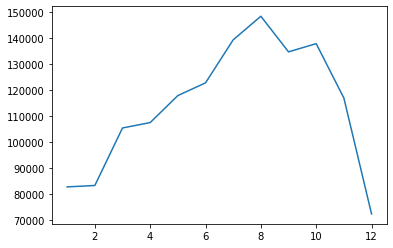

In [61]:
lists = sorted(reviews_count_month.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

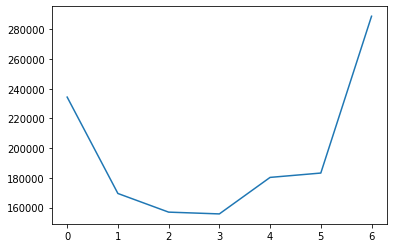

In [62]:
lists = sorted(reviews_count_dayofweek.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

# Data Story

In [95]:
#Instructions: The questions you asked, The trends you investigated, The resulting visualizations and conclusions

In [96]:
#What are the distributions of price, bedroom, bathroom, beds, accommodate variables
#What is the relationship between bedroom, bathroom,beds with price
#What is the relationship between number of reviews, monthly reviews, number of reviews ltm with price
#What is the geographical distribution of listings (longitude and latitude)
#How are the different review scores correlated
#What is the mean price for different neighbourhood grouped by room type
#What is the proportion of listings for room types and bed types
#How is the factor superhost affect price, grouped by neighbourhood
#What is the time series trend of price by neighbourhood from 2015 to 2019
#What is the distribution of future availabilities for listings

In [97]:
#plot histogram of individual variables
def plot_hist(var,log = False):
    if log==False:
        listing_20191205[var].plot(kind='hist',bins=10)
        ci=np.percentile(listing_20191205[var],[2.5,97.5])
        mean=np.mean(listing_20191205[var])
        plt.axvline(mean,color='k')
        plt.axvline(ci[0],color='k',linestyle='--')
        plt.axvline(ci[1],color='k',linestyle='--')
        plt.xlabel(var)
        plt.ylabel('frequency')
        plt.title('Distribution of '+ var)
    else:
        np.log(listing_20191205[var]).plot(kind='hist',bins=10)
        ci=np.percentile(np.log(listing_20191205[var]),[2.5,97.5])
        mean=np.mean(np.log(listing_20191205[var]))
        plt.axvline(mean,color='k')
        plt.axvline(ci[0],color='k',linestyle='--')
        plt.axvline(ci[1],color='k',linestyle='--')
        plt.xlabel('log '+ var)
        plt.ylabel('frequency')
        plt.title('Distribution of '+ var)
    plt.show()
    

In [98]:
listing_20191205.price.describe()

count    39960.000000
mean       225.394494
std        648.646398
min         10.000000
25%         70.000000
50%        110.000000
75%        189.000000
max      25000.000000
Name: price, dtype: float64

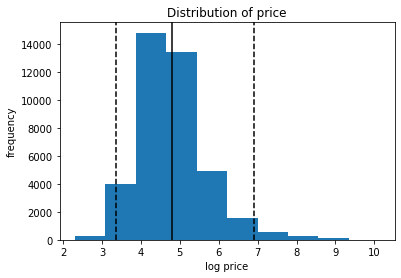

In [99]:
plot_hist('price',True)

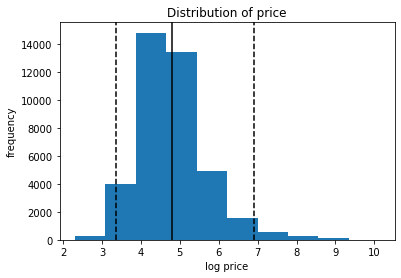

In [100]:
plot_hist('price',True)

In [101]:
listing_20191205.security_deposit.describe()

count     39960.000000
mean        359.010035
std        2168.668303
min           0.000000
25%           0.000000
50%         100.000000
75%         300.000000
max      250000.000000
Name: security_deposit, dtype: float64

In [102]:
listing_20191205.cleaning_fee.describe()

count    39960.000000
mean        81.799650
std         99.174789
min          0.000000
25%         20.000000
50%         55.000000
75%        100.000000
max       2500.000000
Name: cleaning_fee, dtype: float64

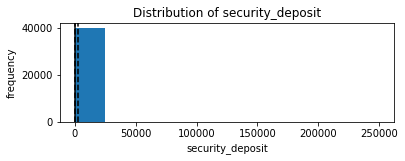

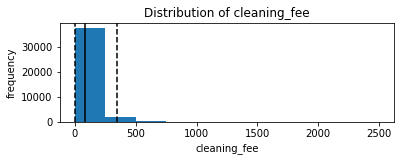

In [103]:
plt.subplot(2,1,1)
plot_sd=plot_hist('security_deposit',False)
plt.subplot(2,1,2)
plot_cf=plot_hist('cleaning_fee',False)

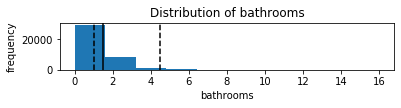

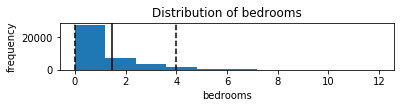

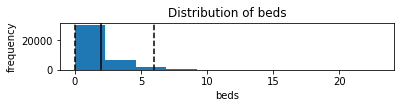

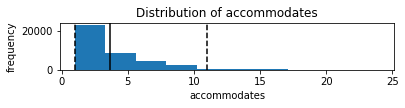

In [104]:
plt.subplot(4,1,1)
plot_sd=plot_hist('bathrooms',False)
plt.subplot(4,1,2)
plot_cf=plot_hist('bedrooms',False)
plt.subplot(4,1,3)
plot_cf=plot_hist('beds',False)
plt.subplot(4,1,4)
plot_cf=plot_hist('accommodates',False)

In [105]:
def plot_scatter(var1,var2,var3,cm):
    if cm=='v':
        listing_20191205.plot.scatter(var1,var2,c=var3,colormap='viridis',figsize=(10,6.5))
    elif cm=='p':
        listing_20191205.plot.scatter(var1,var2,c=var3,colormap=matplotlib.cm.get_cmap('Purples_r'),figsize=(10,6.5))
    elif cm=='m':
        listing_20191205.plot.scatter(var1,var2,c=var3,colormap='plasma',figsize=(10,6.5))
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title('relationship between'+var1+' and '+var2)
    plt.show()


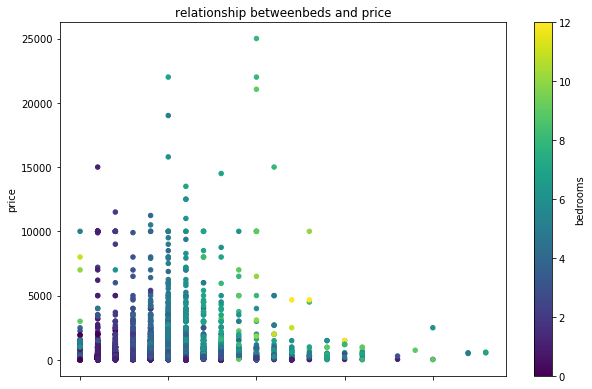

In [106]:
plot_scatter('beds','price','bedrooms','v')

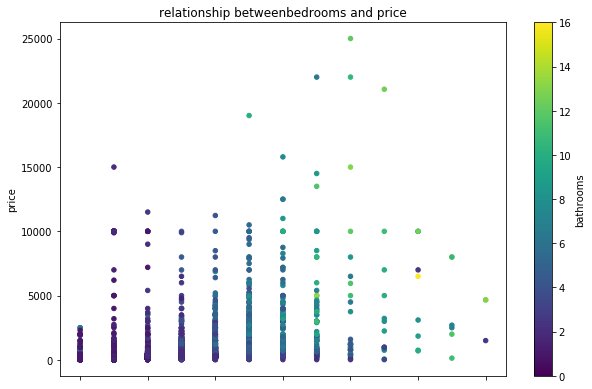

In [107]:
plot_scatter('bedrooms','price','bathrooms','v')

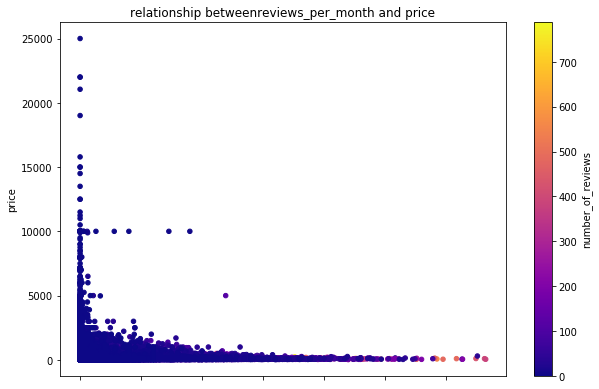

In [108]:
plot_scatter('reviews_per_month','price','number_of_reviews','m')

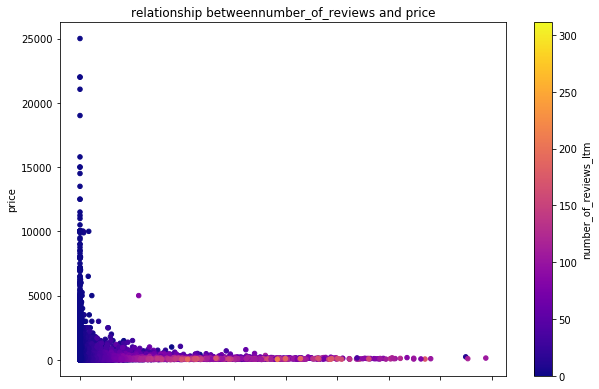

In [109]:
plot_scatter('number_of_reviews','price','number_of_reviews_ltm','m')

In [110]:
#number of reviews, number of reviews ltm-last twelve month
#plot_rw=sns.jointplot(x='number_of_reviews',y='number_of_reviews_ltm',data=listing_20191205)
#plt.show()

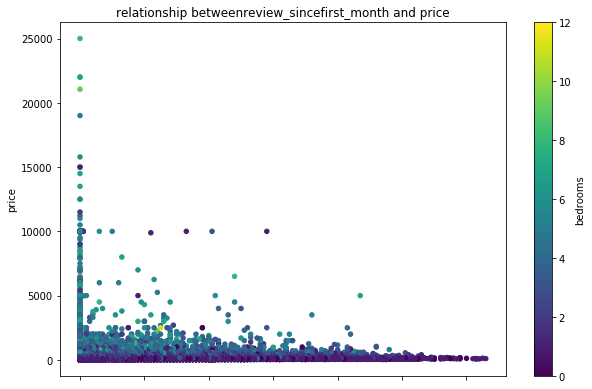

In [46]:
#plot_scatter('review_sincefirst','price','number_of_reviews','v')
listing_20191205.review_sincefirst.head()
listing_20191205['review_sincefirst_month']=listing_20191205['review_sincefirst'].astype('timedelta64[M]')
#listing_20191205['review_sincefirst_month'].dtype
plot_scatter('review_sincefirst_month','price','bedrooms','v')

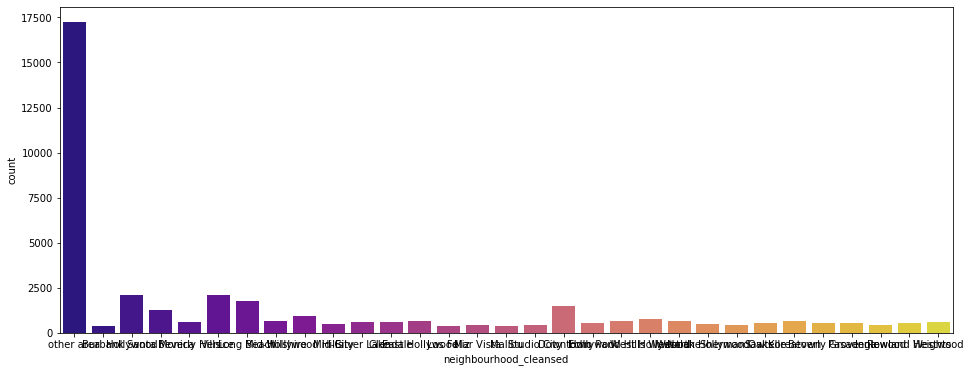

In [47]:
plt.figure(figsize=(16,6))
sns.countplot(listing_20191205['neighbourhood_cleansed'], palette="plasma")

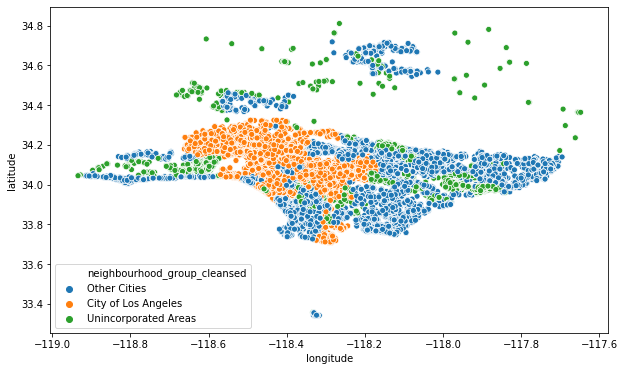

In [48]:
#listing_20191205[['longitude','latitude']].sort_values(ascending=True,by='latitude')
plt.figure(figsize=(10,6))
sns.scatterplot(listing_20191205.longitude,listing_20191205.latitude,hue=listing_20191205.neighbourhood_group_cleansed)
plt.show()

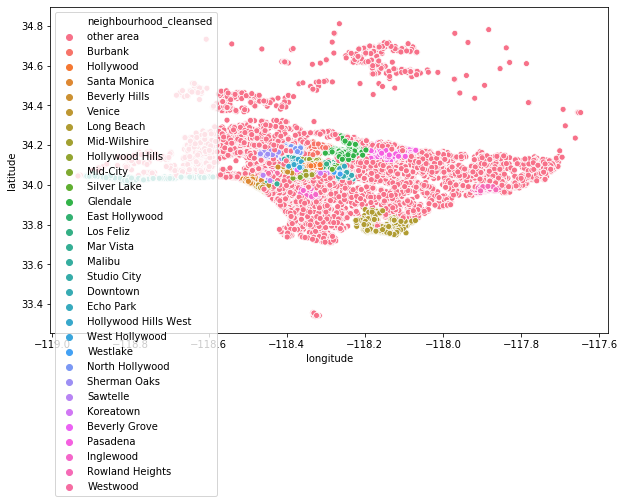

In [49]:
plt.figure(figsize=(10,6))
sns.scatterplot(listing_20191205.longitude,listing_20191205.latitude,hue=listing_20191205.neighbourhood_cleansed)
plt.show()

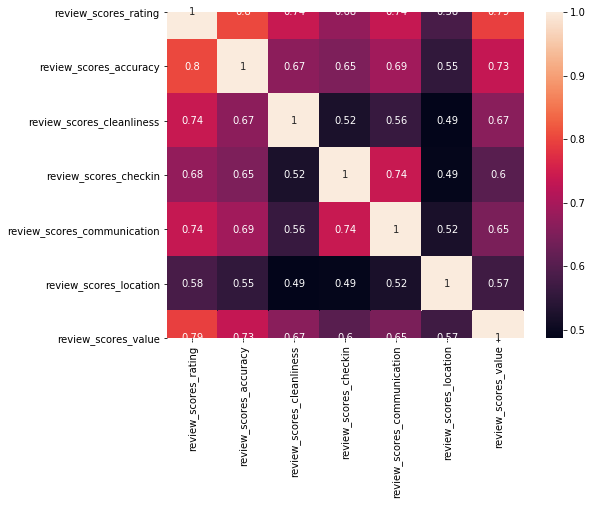

In [608]:
#review scores
rv_cor=listing_20191205[['review_scores_rating','review_scores_accuracy',
                  'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                 'review_scores_location','review_scores_value']].corr(method ='pearson') 
plt.figure(figsize=(8,6))
sns.heatmap(rv_cor,annot=True)    

In [609]:
listing_20191205.bed_type.value_counts()

Real Bed         39575
Futon              145
Pull-out Sofa       97
Airbed              86
Couch               58
Name: bed_type, dtype: int64

In [610]:
listing_20191205.room_type.value_counts()

Entire home/apt    25116
Private room       13035
Shared room         1482
Hotel room           328
Name: room_type, dtype: int64

In [611]:
#how to deal with amenities data, count number of amenities?
listing_20191205.amenities

0        {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1        {TV,"Cable TV",Internet,Wifi,"Air conditioning...
2        {Internet,Wifi,"Air conditioning","Wheelchair ...
3        {Internet,Wifi,Kitchen,Heating,Washer,Dryer,"S...
4        {TV,"Cable TV",Internet,Wifi,"Air conditioning...
                               ...                        
40119    {Wifi,"Air conditioning",Kitchen,"Free parking...
40120    {TV,Wifi,"Air conditioning",Pool,Kitchen,"Free...
40122    {TV,Wifi,"Air conditioning",Kitchen,"Free park...
40123    {TV,Wifi,"Air conditioning",Kitchen,"Free park...
40124    {TV,Wifi,"Air conditioning",Pool,Kitchen,"Free...
Name: amenities, Length: 39961, dtype: object

In [612]:
listing_20191205.room_type.unique()
listing_20191205.groupby('room_type')['price'].mean().sort_values(ascending=False)

room_type
Entire home/apt    297.563505
Hotel room         234.942073
Private room       105.147909
Shared room         57.753036
Name: price, dtype: float64

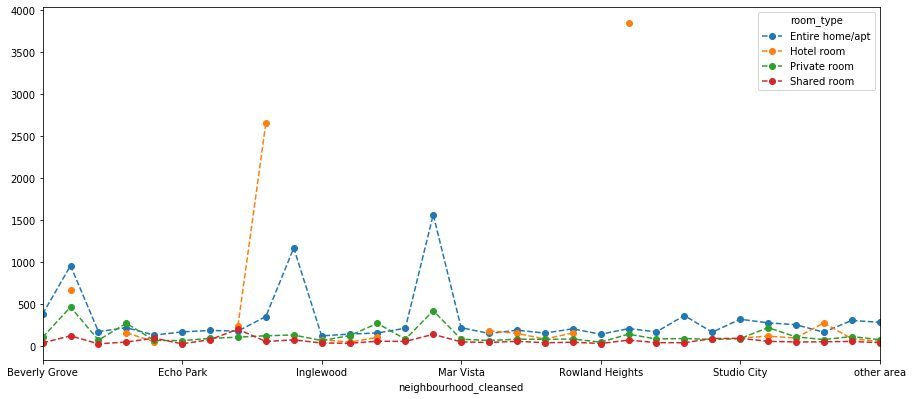

In [613]:
#price by neighbourhood averaged by room type
bynb=listing_20191205.groupby(['neighbourhood_cleansed','room_type'])['price'].mean()
bynb.unstack().plot(marker='o', linestyle='--',figsize=(15,6.5))

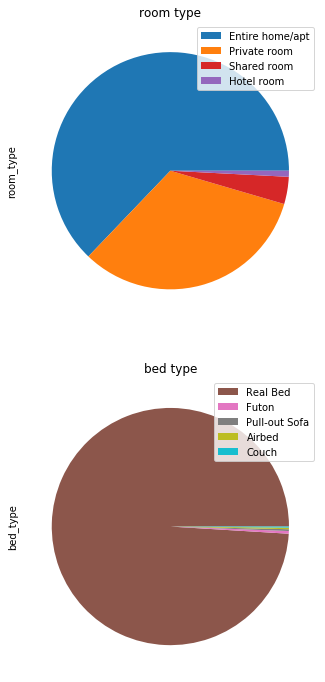

In [591]:
plt.figure(figsize=(6,12))
plt.subplot(2,1,1); listing_20191205.room_type.value_counts().plot(kind='pie',colors=['C0','C1','C3','C4'],labeldistance=None)
plt.title('room type')
plt.legend()
plt.subplot(2,1,2); listing_20191205.bed_type.value_counts().plot(kind='pie',colors=['C5','C6','C7','C8','C9'],labeldistance=None)
plt.title('bed type')
plt.legend()

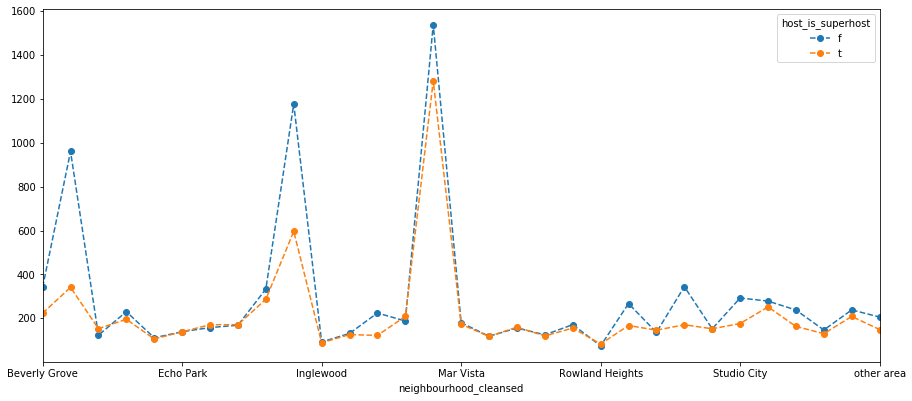

In [592]:
#superhost and price,for the same the location
bysh=listing_20191205.groupby(['neighbourhood_cleansed','host_is_superhost'])['price'].mean()
bysh.unstack().plot(marker='o', linestyle='--',figsize=(15,6.5))

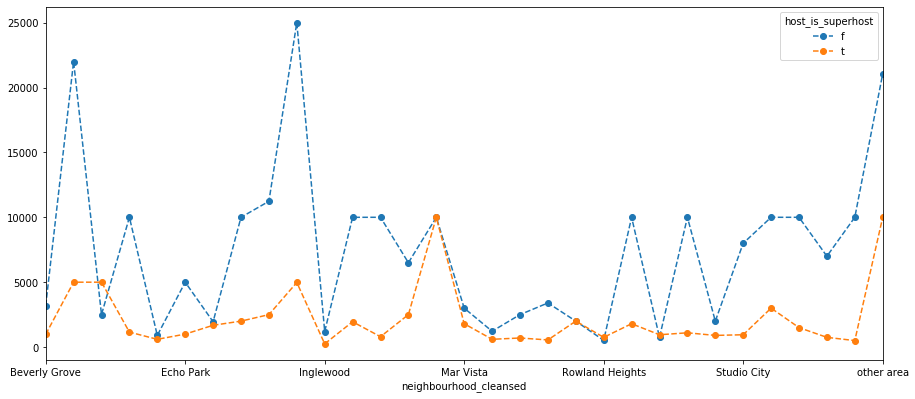

In [593]:
bysh2=listing_20191205.groupby(['neighbourhood_cleansed','host_is_superhost'])['price'].max()
bysh2.unstack().plot(marker='o', linestyle='--',figsize=(15,6.5))

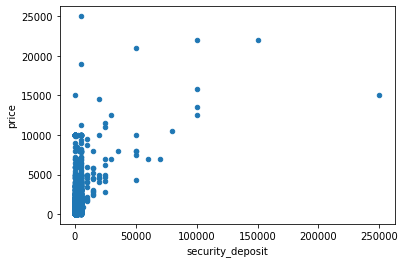

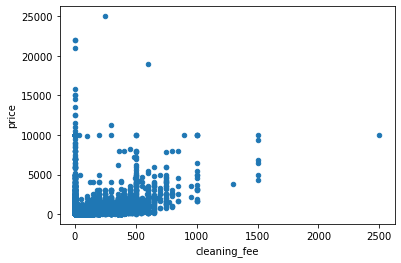

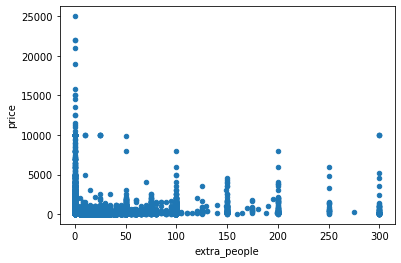

In [594]:
listing_20191205.plot.scatter('security_deposit','price')
listing_20191205.plot.scatter('cleaning_fee','price') 
listing_20191205.plot.scatter('extra_people','price')

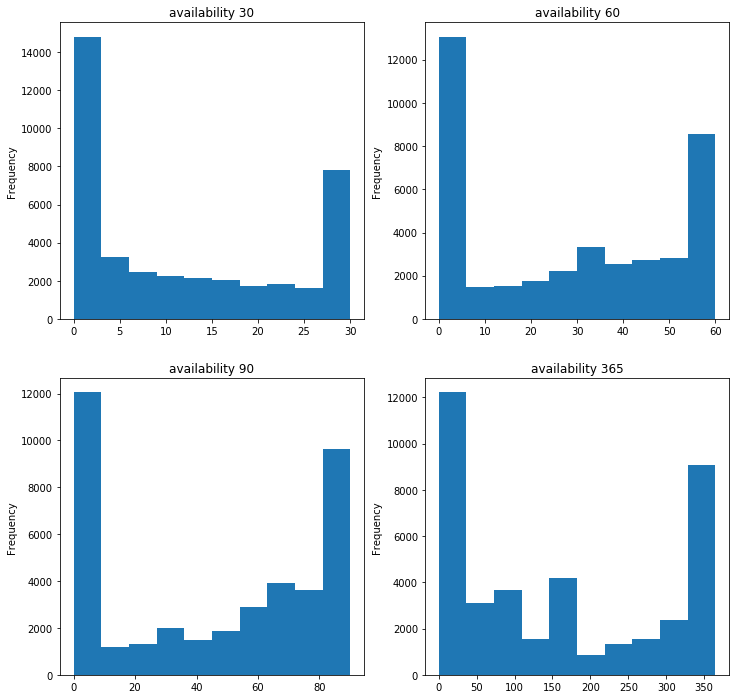

In [112]:
#can't use future availability to predict price tho
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plot_av1=listing_20191205.availability_30.plot(kind='hist')
plt.title('availability 30')
plt.subplot(2,2,2)
plot_av2=listing_20191205.availability_60.plot(kind='hist')
plt.title('availability 60')
plt.subplot(2,2,3)
plot_av3=listing_20191205.availability_90.plot(kind='hist')
plt.title('availability 90')
plt.subplot(2,2,4)
plot_av4=listing_20191205.availability_365.plot(kind='hist')
plt.title('availability 365')
plt.show()

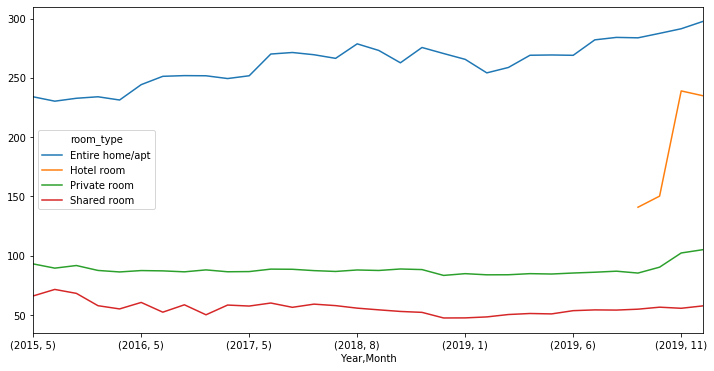

In [125]:
#time series trend of price, by neighbourhood
byym=df.groupby(['Year','Month','room_type'])['price'].mean()
byym.unstack().plot(figsize=(12,6))

Month
1     187.766152
2     188.106445
3     188.510963
4     192.988279
5     189.722727
6     198.304654
7     194.597794
8     201.501757
9     200.666034
10    204.017241
11    204.364650
12    211.437774
Name: price, dtype: float64

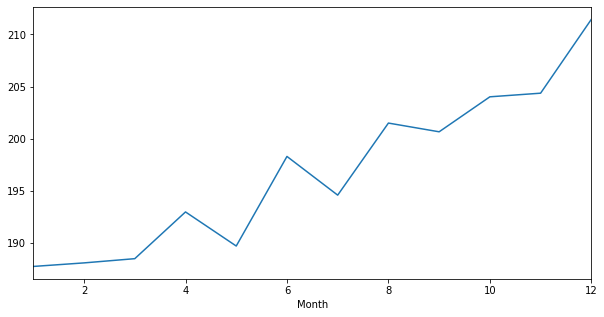

In [133]:
bym=df.groupby(['Month'])['price'].mean()
bym.plot(figsize=(10,5))
bym

In [33]:
def plotfit(var1,var2):
    model = smf.ols(formula=var1+' ~ 1+ '+var2,data=listing_20191205)
    fit = model.fit()
    plt.scatter(listing_20191205[var2],listing_20191205[var1])
    plt.plot(listing_20191205[var2],fit.predict(listing_20191205),color='r')

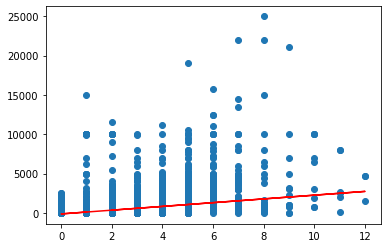

In [34]:
plotfit('price','bedrooms')